<a href="https://colab.research.google.com/github/ikki02/Python/blob/master/DataScience/web_optimization_ml/2_%E7%A2%BA%E7%8E%87%E7%9A%84%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 概要
『Web最適化ではじめる機械学習』の第二章に当たる部分のまとめ
# 目次
- 確率的プログラミング
- レビュースコアの推論
 - カテゴリカル分布（多項分布） × ディリクレ分布
- 滞在時間の推論
 - 指数分布 × 一様分布


# 確率的プログラミング
確率的プログラミングとは、第1章で見たようなモデリングと分析をライブラリを用いて手間を減らし、事後分布を推論していくことである。「ベイズアップデート」のipynbを見れば分かると思うが、二項分布やベータ分布を全部自前で関数を実装していた。だが、それは一般的な関数なので、それをライブラリ化したものを使おうということである。ここではPyMC3を用いて、K個の離散値や連続値で表される確率分布に対する問題も解いていく。

In [1]:
!pip install arviz
!pip install -U pymc3

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

In [3]:
# まずはこれまで見てきたデザインAとBのクリック率θの事後分布の推論をPyMC3を用いて実装し直してみる
# PyMC3ではMCMCという大量の乱数を生成してどんどん状態を更新していくアルゴリズム
# マルコフ性とは、ラプラスのように、未来の状態が現在の状態のみで規定されるという性質をもつもののこと
# モンテカルロ法は、乱数を大量に生成することで何らかの問題を解く方法の総称
# バーンイン：探索の初期値は無作為に選ばれるため最適なパラメータとはかけ離れることが多い。その初期値の影響を取り除いて捨ててしまう期間のことをバーンインという。
N = 40
a = 2
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1) # 0~1のθに関する一様分布
    #theta = pm.Beta('theta', alpha=1, beta=1) # ベータ分布で上記一様分布を実装する場合
    obs = pm.Binomial('a', p=theta, n=N, observed=a)
    trace = pm.sample(5000, chains=2) # 推論開始。chainsは並行して一連のサンプリングを行う回数。ここでは5000*2の10000個のサンプルを得る。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


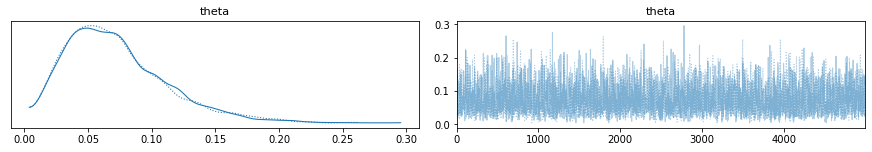

In [4]:
# 左側は対象の確率変数について推論された事後分布
# 右側はバーンイン以降に得られたサンプルの軌跡。ある一定の分布に収束していれば問題ないが、フラフラしているとマルコフ連鎖が収束していない兆候である。今回は大丈夫な例。
with model:
  pm.traceplot(trace)

In [5]:
# 代表的な統計量の確認
with model:
  print(pm.summary(trace, hdi_prob=0.95))

        mean    sd  hdi_2.5%  hdi_97.5%  ...  ess_sd  ess_bulk  ess_tail  r_hat
theta  0.072  0.04     0.008       0.15  ...  3759.0    3260.0    3199.0    1.0

[1 rows x 11 columns]


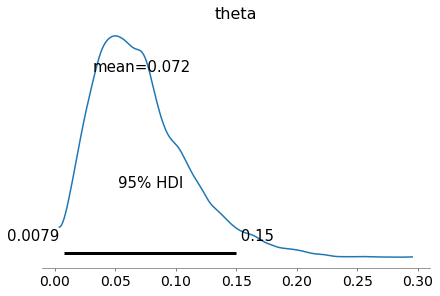

In [6]:
# 超便利。事後分布をHDIとともに描画するメソッド。
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)

In [7]:
# デザイン案Aのクリック率が1%以上であることを確認する。99%なのでそう結論づけよう。
print((trace['theta'] - 0.01 > 0).mean())

0.9922


In [8]:
# デザインAとデザインBの事後分布の推論を一気にやる
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2) # 2つ評価したい場合はshape引数に2を渡す。
  obs = pm.Binomial('obs', p=theta, n=[40, 50], observed=[2, 4]) # 2つ評価する場合はリスト内に順にパラメータを渡すことができる
  trace = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


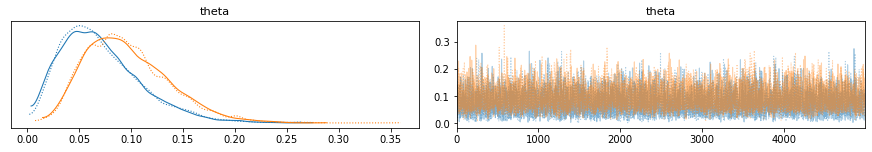

In [9]:
# 一気に可視化できる
with model:
  pm.traceplot(trace, ['theta'], compact=True)

In [10]:
# デザインBのクリック率はデザインAよりも大きいことを確かめる。正直微妙である。
print((trace['theta'][:, 1] - trace['theta'][:, 0] > 0).mean())

0.6733


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


0.9996


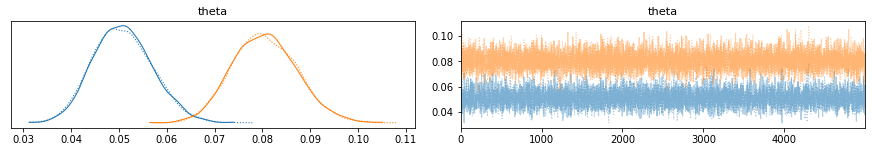

In [11]:
# 例のごとくサンプル数を増やしたらちゃんと変わること確認。綺麗にデザインBの方が良いという結果が得られる。
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128])
  trace = pm.sample(5000, chains=2)
  print((trace['theta'][:, 0] < trace['theta'][:, 1]).mean())
  pm.traceplot(trace, ['theta'], compact=True)

# レビュースコアの推論
K個の離散値の事後分布を推論する。  
レビュースコアという1~5点の離散値が与えられるレビュースコアについて、データからそれらの事後分布を一気に推論できる。
- 尤度関数：カテゴリカル分布
 - 簡単に言えばベルヌーイ分布のK次元版。0か1の二値を取るのではなく、K個の値をとりうる試行に使う。
- 事前分布（事後分布）：ディリクレ分布  
 - ディリクレ分布のパラメータはK次元ベクトルα。すべての要素は正の実数で表される。

これらは共役である！


In [12]:
# 商品Aのレビューデータ用意
n_a = [20, 10, 36, 91, 170] # 商品Aについて1~5点がどのように得られたか配列を作る。星1が20個、星2が10個、、、みたいな感じ。
data = [0 for _ in range(n_a[0])]
data += [1 for _ in range(n_a[1])]
data += [2 for _ in range(n_a[2])]
data += [3 for _ in range(n_a[3])]
data += [4 for _ in range(n_a[4])]
print('データの一部抜粋：', data[:40])

データの一部抜粋： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [13]:
with pm.Model() as model_a:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1])) # パラメータαのK次元ベクトルの要素が全て1のとき、多カテゴリの一様分布を意味する。
  obs = pm.Categorical('obs', p=theta, observed=data)
  trace_a = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


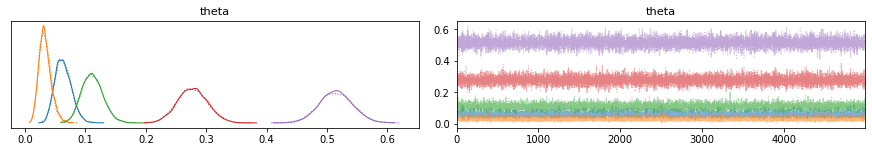

In [14]:
# 一気にK個分の事後分布を出せる。もう一つ下のセルの事後分布の結果と合わせてみると、確率の高い順に5, 4, 3, 1, 2のレビューが得られることが分かる。
with model_a:
  pm.traceplot(trace_a)

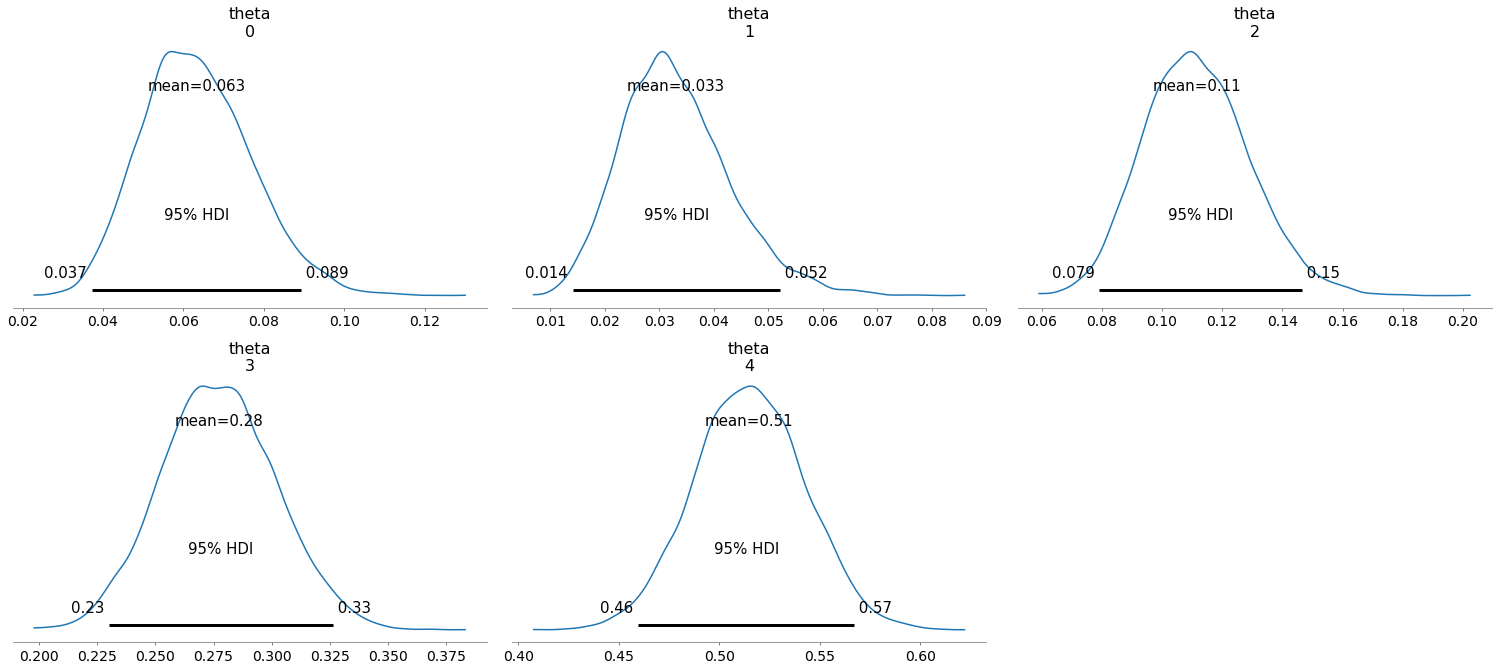

In [15]:
# 星5の95%HDIが0.5周辺にあるので、半分くらいのレビューは星5だと分かる。
with model_a:
  pm.plot_posterior(trace_a, hdi_prob=0.95)

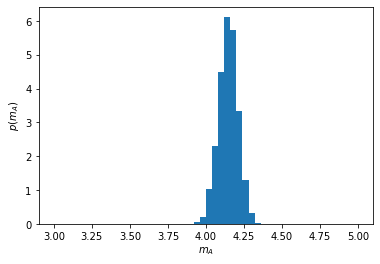

In [16]:
# 商品Aのレビュー期待値を求めてみよう
# 期待値mは、1*θ1 + 2*θ2 + 3*θ3 * 4*θ4 + 5*θ5

weights = np.array([1, 2, 3, 4, 5])
m_a = np.matmul(trace_a['theta'], weights)
# 可読性重視ならこう書くことも可能。上は行列の掛け算（ベクトルとの内積）でパフォーマンス重視の書き方。
# m_a = [sum(row * weights) for row in trace_a['theta']]

plt.hist(m_a, range=(3, 5), bins=50, density=True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show()

この結果を解釈すると、商品Aのレビュースコアの平均点は4.0~4.3点までの狭い区間に集中することが分かる。少なくとも4.0よりは高いと言えそう。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.


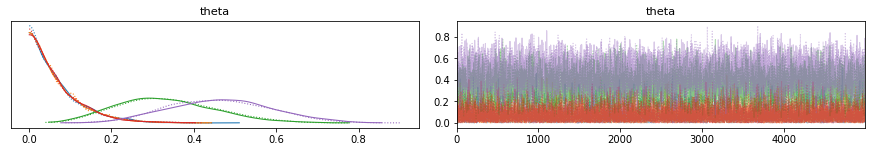

In [17]:
# 商品Bでも試してみよう
# ただし、今度はカテゴリカル分布を拡張した多項分布を利用する。
n_b = np.array([0, 0, 4, 0, 6]) # 商品Bのレビュー結果を用意する

with pm.Model() as model_b:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Multinomial('obs', p=theta, n=n_b.sum(), observed=n_b)
  trace_b = pm.sample(5000, chains=2)
  pm.traceplot(trace_b)

商品Bは得られたレビューデータが少ないので、裾がかなり広い事後分布が得られた。

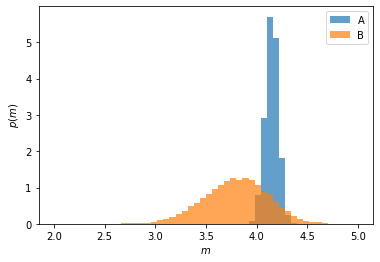

In [18]:
# 商品Aと商品Bのレビュースコアのばらつきを可視化してみる
m_b = np.matmul(trace_b['theta'], weights)
plt.hist(m_a, range=(2, 5), bins=50, density=True, label='A', alpha=0.7)
plt.hist(m_b, range=(2, 5), bins=50, density=True, label='B', alpha=0.7)
plt.xlabel(r'$m$')
plt.ylabel(r'$p(m)$')
plt.legend()
plt.show()

# 滞在時間の推論
ユーザーが特定のウェブサイトに滞在した秒数などのように連続値で表されるデータの事後分布の推論
- 尤度関数：指数分布  
ある一定の確率で発生するイベントの時間間隔を扱うのによく使われる確率分布

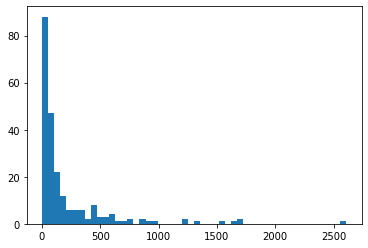

In [19]:
# 架空のウェブサイトの滞在時間のデータセットをダウンロードして可視化してみる
# CSVの各行には1アクセスあたりの滞在時間を秒数で表している。
import urllib
url = 'https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv'
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]
plt.hist(data, bins=50)
plt.show()

0が多く、ほとんどのユーザーはすぐ離脱することが分かる。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8824462579820563, but should be close to 0.8. Try to increase the number of tuning steps.


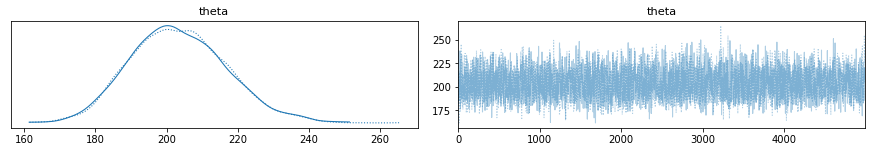

In [20]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=3000)
  obs = pm.Exponential('obs', lam=1/theta, observed=data) # θの代わりにその逆数であるλ＝1/θを引数とする
  trace = pm.sample(5000, chains=2)
  pm.traceplot(trace)

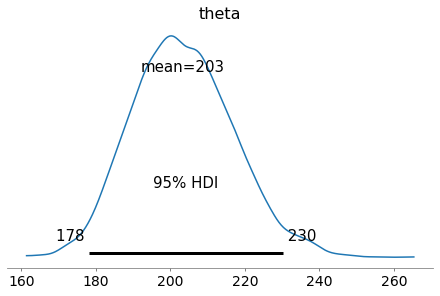

In [21]:
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)

指数分布の期待値はθなので、これはそのまま滞在時間の期待値の確率分布として読み取ることができる。その結果、ほとんど177秒〜230秒の間に収まることがわかった。実際にはほとんどのユーザーはすぐにwebサイトを去るのでこのような値はとらないが、期待値θはデザイン案のポテンシャルを測る数値と言えるだろう。ある操作を加えることで滞在時間が伸びたことを確かめたいなら、この確率変数θの事後分布から導き出される統計量を比較して定量的評価を行えば良い。